# Toronto Shelter Data: An Exploratory Data Analysis of Occupancy Rates in 2021

## Maya Ghai

## INF2178

## February 4th, 2023


In [230]:
# Import modules
import numpy as np
import pandas as pd
from sklearn import datasets
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from scipy.stats import ttest_ind

# Read file
filename = 'INF2178_A1_data.xlsx'
df = pd.read_excel(filename)

# Defining Functions Used:

In [231]:

def get_summary_statistics(dataset, dataset_name):
    '''
    Calculate and display summary statistics for a given dataset.

    Parameters:
    - dataset (pandas.Series): The dataset for which summary statistics are calculated.
    - dataset_name (str): The name of the dataset.

    Returns:
    - tuple: A tuple containing the mean, median, minimum, maximum, and interquartile range (IQR) of the dataset.
    '''

    mean = np.round(np.mean(dataset), 2)
    median = np.round(np.median(dataset), 2)
    min_value = np.round(dataset.min(), 2)
    max_value = np.round(dataset.max(), 2)

    # Calculate IQR
    q1 = np.percentile(dataset, 25)
    q3 = np.percentile(dataset, 75)
    iqr = np.round(q3 - q1, 2)

    # Print dataset name
    print(f"Summary Statistics for Dataset: {dataset_name}")

    # Create a formatted table
    summary_table = pd.DataFrame({
        'Statistic': ['Mean', 'Median', 'Minimum', 'Maximum', 'IQR'],
        'Value': [mean, median, min_value, max_value, iqr]
    })

    print(summary_table)

    return mean, median, min_value, max_value, iqr

In [232]:
def boxplot(dataset, categorical_column, quantitative_column):
    """
    Create a boxplot for each level of the categorical variable with summary statistics.

    Parameters:
    - dataset (pd.DataFrame): The dataset containing the data.
    - categorical_column (str): The column name of the categorical variable.
    - quantitative_column (str): The column name of the quantitative variable.

    Returns:
    - None: Displays the boxplots with summary statistics.
    """

    # Set a larger figure size
    plt.figure(figsize=(14, 8))

    # Create a boxplot for each level of the categorical variable
    graph = sns.boxplot(x=categorical_column, y=quantitative_column, data=dataset)

    # Annotate the boxplot with summary statistics
    for category in dataset[categorical_column].unique():
        box_datapoints = dataset.loc[dataset[categorical_column] == category, quantitative_column]
        mean, median, min_value, max_value, iqr = get_summary_statistics(box_datapoints,f"{category}") # Make a call to our summary statistics function
        label_text = f"\nMedian: {median}\nIQR: {iqr}" # Display median and IQR on the appropriate boxplot
        graph.text(category,-0.2,label_text,ha='center',va='center')

    plt.xlabel(categorical_column)
    plt.ylabel(quantitative_column)
    plt.title(f'Boxplot of {quantitative_column} for each level of {categorical_column}')
    plt.show()

In [233]:
def plot_programs_by_month(data, sector, figsize=(12, 6)):
    """
    Create a boxplot for 'Emergency' and 'Transitional' percent capacity for each month in a specified sector.

    Parameters:
    - data (pd.DataFrame): The DataFrame containing the data.
    - sector (str): The sector for which the boxplot is created.
    - figsize (tuple, optional): Figure size. Default is (12, 6).

    Returns:
    - None: Displays the boxplot with 'Emergency' and 'Transitional' percent capacity for each month.
    """
    # Select data for the specified sector
    sector_data = data[data['SECTOR'] == sector]

    # Create a boxplot for 'Emergency' and 'Transitional' percent capacity for each month
    plt.figure(figsize=figsize)
    sns.boxplot(x='MONTH', y='PERCENT_CAPACITY', hue='PROGRAM_MODEL', data=sector_data, palette='Set1')
    plt.title(f'Boxplot of Emergency and Transitional Percent Capacity for {sector} Sector')
    plt.xlabel('MONTH')
    plt.ylabel('Percent Capacity')
    plt.legend(title='Program Model')

    plt.tight_layout()
    plt.show()


In [234]:
def compare_programs_by_month(data, sector):
  """
  Compare the 'Emergency' and 'Transitional' programs by month for a specified sector.

  Parameters:
  - data (pd.DataFrame): The DataFrame containing the data.
  - sector (str): The sector for which the comparison is performed.

  Returns:
  - None: Displays the results of independent samples t-test for each month.
  """

  # Select data for the specified sector
  sector_data = data[data['SECTOR'] == sector]

  # Define the months in your data
  months = sector_data['MONTH'].unique()

  # Perform independent samples t-test for each month
  alpha = 0.05

  # Print header
  print("{:<5} {:<15} {:<25} {:<30} {:<25}".format("Month", "T-statistic", "P-value (uncorrected)",
                                                  "Adjusted P-value (Bonferroni)", "Significant Difference"))
  print("-" * 100)  # Line separator

  for month in months:
    # Select data for the specific month
    month_data = sector_data[sector_data['MONTH'] == month]

    # Select data for 'Emergency' and 'Transitional' programs in the current month
    emergency_data = month_data[month_data['PROGRAM_MODEL'] == 'Emergency']['PERCENT_CAPACITY']
    transitional_data = month_data[month_data['PROGRAM_MODEL'] == 'Transitional']['PERCENT_CAPACITY']

    # Perform independent samples t-test
    t_stat, p_value = ttest_ind(emergency_data, transitional_data, equal_var=False)  # Use equal_var=False for Welch's t-test

    # Correct for multiple comparisons using Bonferroni correction
    adjusted_alpha = alpha / len(months)  # Bonferroni correction
    adjusted_p_value = round(p_value * len(months), 3)  # Round adjusted p-value to 3 decimal places

    # Determine significance
    significance = "* Yes" if p_value < adjusted_alpha else "No"

    # Print data for the row
    print("{:<5} {:<15.3f} {:<25.3f} {:<30.3f} {:<25}".format(month, t_stat, p_value, adjusted_p_value,
                                                                  significance))

# Data Transformation

**Creating New Columns**: PERCENT_CAPACITY as a double value ranging from 0 to 1.00, SPACE_AVAILABLE: A binary indicator denoting whether there is space available in the shelter on the given day.
AVAILABLE_SPACE: The percentage of available space within the shelter.
MONTH: Transformed from 'OCCUPANCY_DATE' to represent the month of shelter occupancy.


In [235]:
housingEntire = df.loc[:, ['OCCUPANCY_DATE', 'CAPACITY_TYPE', 'OCCUPIED_BEDS', 'OCCUPIED_ROOMS', 'CAPACITY_ACTUAL_BED', 'CAPACITY_ACTUAL_ROOM', 'SECTOR', 'PROGRAM_MODEL']].copy()

# Update 'Percent Capacity' where 'CAPACITY_TYPE' is 'Bed Based Capacity'
bed_based_mask = housingEntire['CAPACITY_TYPE'] == 'Bed Based Capacity'
housingEntire.loc[bed_based_mask, 'PERCENT_CAPACITY'] = housingEntire.loc[bed_based_mask, 'OCCUPIED_BEDS'] / housingEntire.loc[bed_based_mask, 'CAPACITY_ACTUAL_BED']

# Update 'Percent Capacity' where 'CAPACITY_TYPE' is 'Room Based Capacity'
room_based_mask = housingEntire['CAPACITY_TYPE'] == 'Room Based Capacity'
housingEntire.loc[room_based_mask, 'PERCENT_CAPACITY'] = housingEntire.loc[room_based_mask, 'OCCUPIED_ROOMS'] / housingEntire.loc[room_based_mask, 'CAPACITY_ACTUAL_ROOM']

# Update 'OCCUPANCY_DATE' and 'MONTH'
housingEntire['OCCUPANCY_DATE'] = pd.to_datetime(housingEntire['OCCUPANCY_DATE'])
housingEntire['MONTH'] = housingEntire['OCCUPANCY_DATE'].dt.month

# Map numeric months to their short names
month_short_name_mapping = {1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
                            7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}
housingEntire['MONTH'] = housingEntire['MONTH'].map(month_short_name_mapping)

# Drop rows where 'PROGRAM_MODEL' or 'SECTOR' is null
housingEntire = housingEntire.dropna(subset=['PROGRAM_MODEL', 'SECTOR'])


Examining Percent Capacity Column

Kurtosis: 11.94
Skewness: -3.14

Summary Statistics for Dataset: Percent Capacity Entire
  Statistic  Value
0      Mean   0.93
1    Median   1.00
2   Minimum   0.01
3   Maximum   1.01
4       IQR   0.08


(0.93, 1.0, 0.01, 1.01, 0.08)

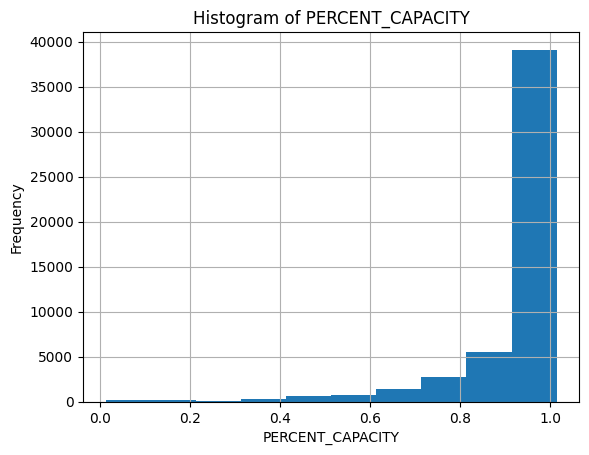

In [236]:
housingEntire['PERCENT_CAPACITY'].hist(label="Distribution of Percent Capacity")
plt.title('Histogram of PERCENT_CAPACITY')
plt.xlabel('PERCENT_CAPACITY')
plt.ylabel('Frequency')

# Calculate kurtosis and skewness
kurt = stats.kurtosis(housingEntire['PERCENT_CAPACITY'])
skewness = stats.skew(housingEntire['PERCENT_CAPACITY'])

# Print the results
print(f'Kurtosis: {kurt :.2f}')
print(f'Skewness: {skewness: .2f}\n')

get_summary_statistics(housingEntire['PERCENT_CAPACITY'],"Percent Capacity Entire")


In [237]:
# Four values of percent capacity are greater than 1 (overcapacity).
overcapacity = housingEntire.loc[housingEntire['PERCENT_CAPACITY']>1.00]
# Update these outlier percentages to equal 1.00 to fit within our assumptions of range (0-100)
housingEntire.loc[housingEntire['PERCENT_CAPACITY'] > 1.00, 'PERCENT_CAPACITY'] = 1.00

# EDA on Transformed Data

Summary Statistics for Dataset: Room Based Capacity
  Statistic  Value
0      Mean   0.93
1    Median   1.00
2   Minimum   0.01
3   Maximum   1.00
4       IQR   0.04
Summary Statistics for Dataset: Bed Based Capacity
  Statistic  Value
0      Mean   0.93
1    Median   1.00
2   Minimum   0.02
3   Maximum   1.00
4       IQR   0.10


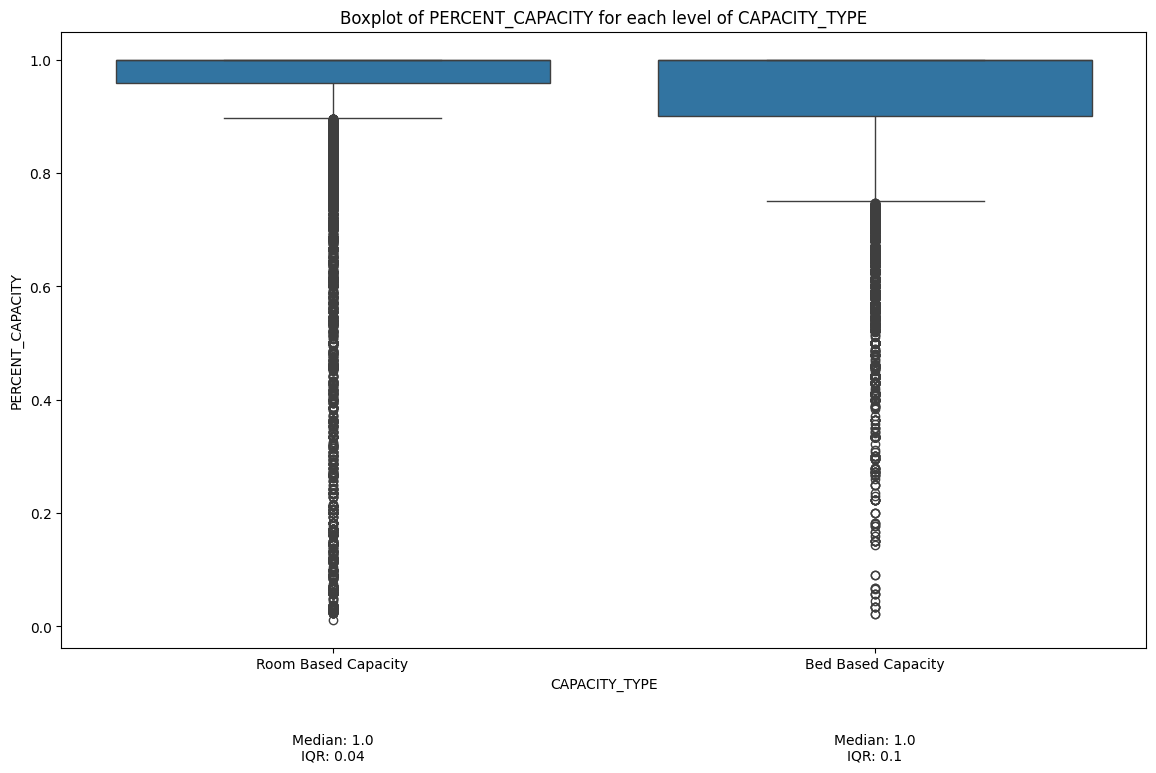

In [238]:
boxplot(housingEntire,'CAPACITY_TYPE','PERCENT_CAPACITY')

Summary Statistics for Dataset: Emergency
  Statistic  Value
0      Mean   0.94
1    Median   1.00
2   Minimum   0.01
3   Maximum   1.00
4       IQR   0.05
Summary Statistics for Dataset: Transitional
  Statistic  Value
0      Mean   0.88
1    Median   0.92
2   Minimum   0.22
3   Maximum   1.00
4       IQR   0.18


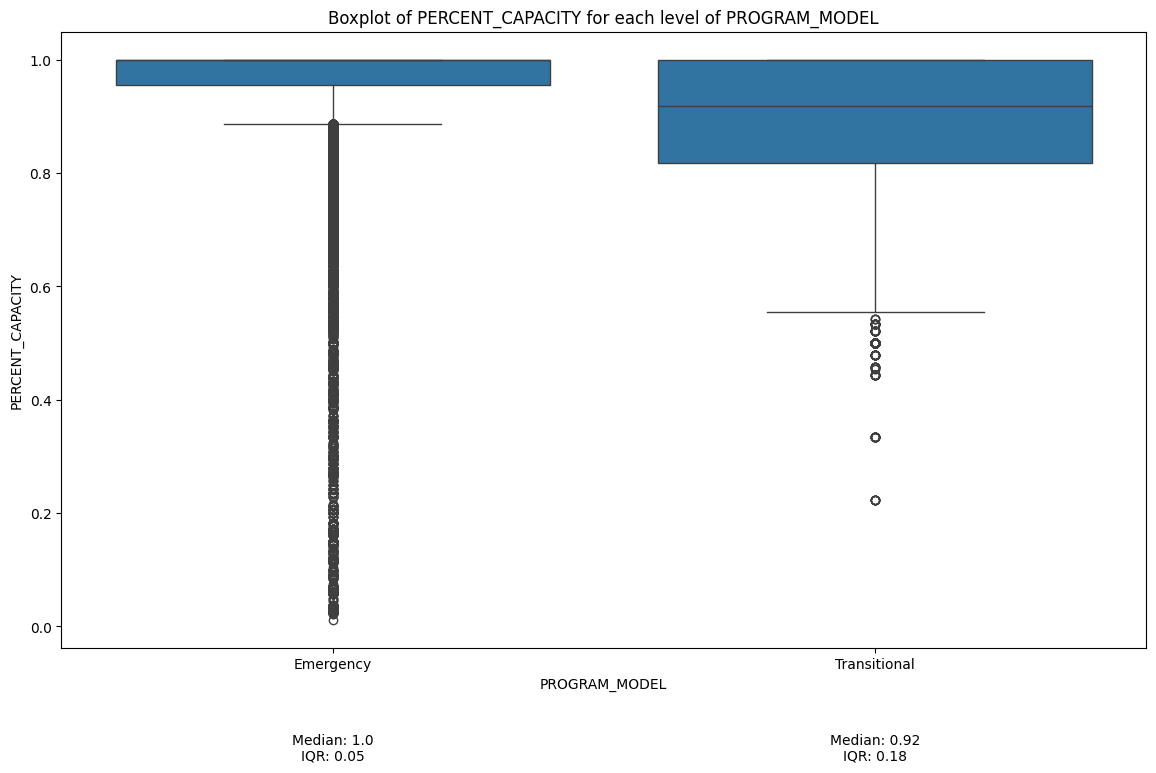

In [239]:
boxplot(housingEntire, 'PROGRAM_MODEL', 'PERCENT_CAPACITY')

Summary Statistics for Dataset: Families
  Statistic  Value
0      Mean   0.92
1    Median   1.00
2   Minimum   0.08
3   Maximum   1.00
4       IQR   0.12
Summary Statistics for Dataset: Mixed Adult
  Statistic  Value
0      Mean   0.91
1    Median   1.00
2   Minimum   0.01
3   Maximum   1.00
4       IQR   0.09
Summary Statistics for Dataset: Men
  Statistic  Value
0      Mean   0.97
1    Median   1.00
2   Minimum   0.14
3   Maximum   1.00
4       IQR   0.03
Summary Statistics for Dataset: Women
  Statistic  Value
0      Mean   0.95
1    Median   1.00
2   Minimum   0.09
3   Maximum   1.00
4       IQR   0.05
Summary Statistics for Dataset: Youth
  Statistic  Value
0      Mean   0.90
1    Median   0.94
2   Minimum   0.28
3   Maximum   1.00
4       IQR   0.14


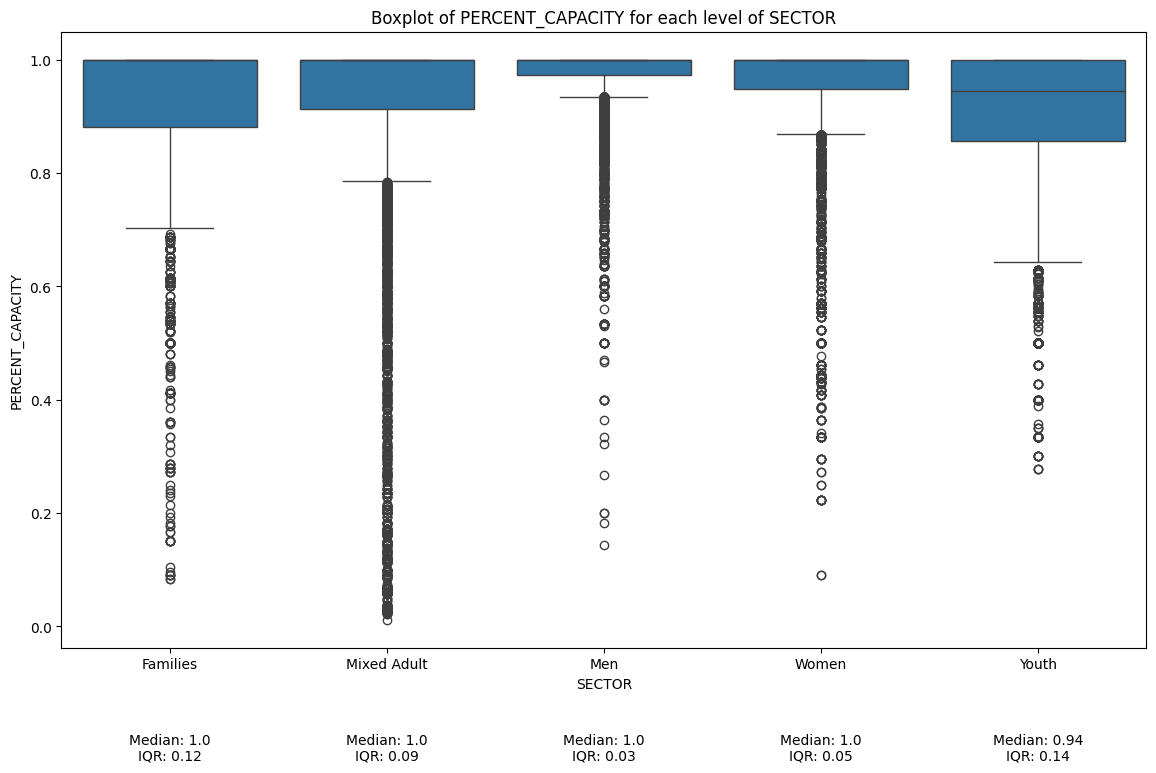

In [240]:
boxplot(housingEntire, 'SECTOR', 'PERCENT_CAPACITY')

Summary Statistics for Dataset: Jan
  Statistic  Value
0      Mean   0.93
1    Median   1.00
2   Minimum   0.18
3   Maximum   1.00
4       IQR   0.08
Summary Statistics for Dataset: Feb
  Statistic  Value
0      Mean   0.94
1    Median   1.00
2   Minimum   0.11
3   Maximum   1.00
4       IQR   0.07
Summary Statistics for Dataset: Mar
  Statistic  Value
0      Mean   0.93
1    Median   1.00
2   Minimum   0.10
3   Maximum   1.00
4       IQR   0.08
Summary Statistics for Dataset: Apr
  Statistic  Value
0      Mean   0.93
1    Median   1.00
2   Minimum   0.25
3   Maximum   1.00
4       IQR   0.09
Summary Statistics for Dataset: May
  Statistic  Value
0      Mean   0.91
1    Median   0.99
2   Minimum   0.05
3   Maximum   1.00
4       IQR   0.10
Summary Statistics for Dataset: Jun
  Statistic  Value
0      Mean   0.91
1    Median   0.98
2   Minimum   0.02
3   Maximum   1.00
4       IQR   0.11
Summary Statistics for Dataset: Jul
  Statistic  Value
0      Mean   0.91
1    Median   0.99
2   Min

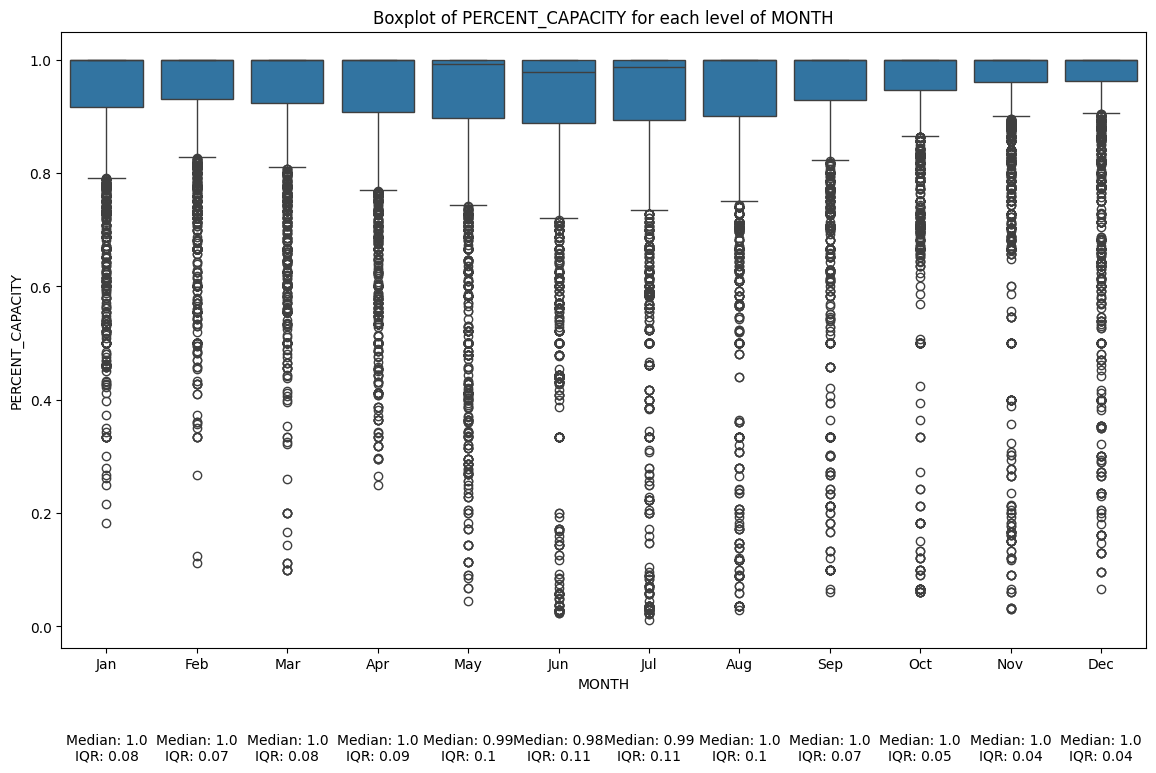

In [241]:
boxplot(housingEntire, 'MONTH', 'PERCENT_CAPACITY')

Analyzing Monthly Trends

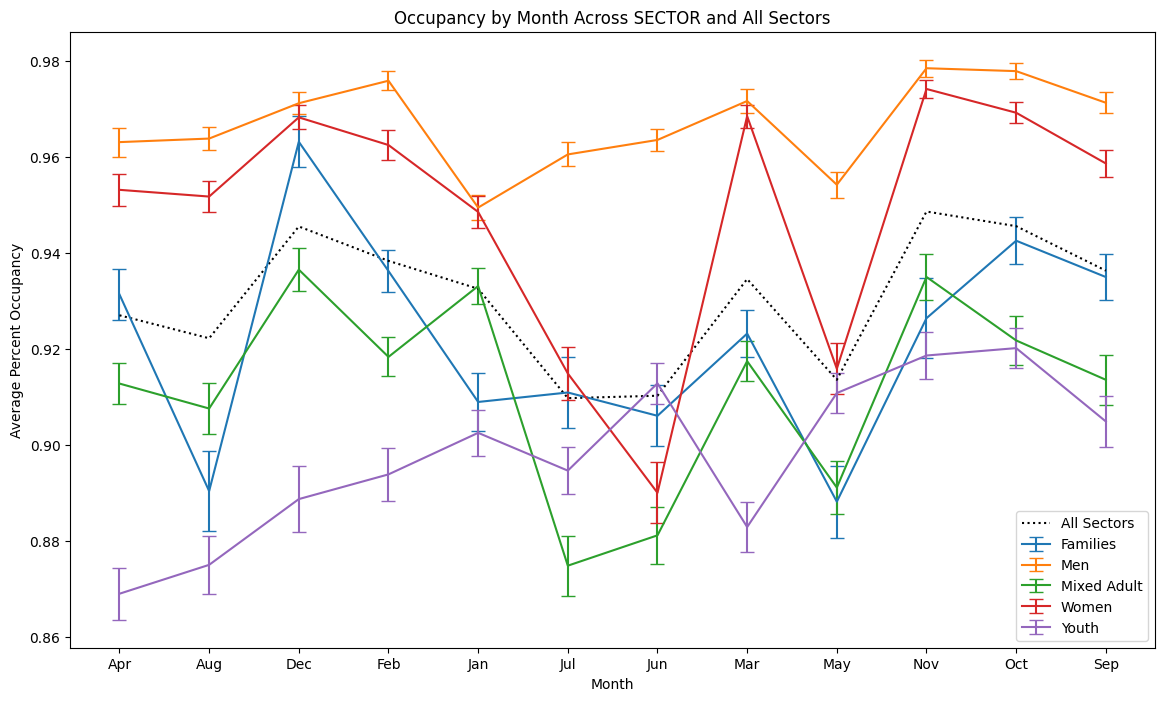

In [248]:
# Group by 'SECTOR' and 'Month', calculating average percent occupancy and SEM
occupancy_by_sector_and_month = housingEntire.groupby(['SECTOR', 'MONTH'])['PERCENT_CAPACITY'].agg(['mean', 'sem']).reset_index()

# Pivot the table
avg_percent_occupancy_by_sector_and_month = occupancy_by_sector_and_month.pivot_table(index='MONTH', columns='SECTOR', values='mean')
sem_percent_occupancy_by_sector_and_month = occupancy_by_sector_and_month.pivot_table(index='MONTH', columns='SECTOR', values='sem')

# Group by 'MONTH', calculating average percent occupancy and SEM
occupancy_by_month = housingEntire.groupby('MONTH')['PERCENT_CAPACITY'].agg(['mean', 'sem']).reset_index()

# Plot the results on the same visualization
plt.figure(figsize=(14, 8))

# Plot for individual sectors
for sector in avg_percent_occupancy_by_sector_and_month.columns:
    plt.errorbar(avg_percent_occupancy_by_sector_and_month.index,
                 avg_percent_occupancy_by_sector_and_month[sector],
                 yerr=sem_percent_occupancy_by_sector_and_month[sector],
                 label=f'{sector}',
                 capsize = 5)

plt.plot(occupancy_by_month['MONTH'],
         occupancy_by_month['mean'],
         color='black',
         linestyle='dotted',
         label='All Sectors')

plt.xlabel('Month')
plt.ylabel('Average Percent Occupancy')
plt.title('Occupancy by Month Across SECTOR and All Sectors')
plt.legend()
plt.show()

# Independent T-Test of Womens Sector

In [243]:
compare_programs_by_month(housingEntire, sector='Women')

Month T-statistic     P-value (uncorrected)     Adjusted P-value (Bonferroni)  Significant Difference   
----------------------------------------------------------------------------------------------------
Jan   17.913          0.000                     0.000                          * Yes                    
Feb   10.583          0.000                     0.000                          * Yes                    
Mar   10.909          0.000                     0.000                          * Yes                    
Apr   5.859           0.000                     0.000                          * Yes                    
May   -1.340          0.181                     2.172                          No                       
Jun   2.562           0.011                     0.134                          No                       
Jul   3.941           0.000                     0.001                          * Yes                    
Aug   9.333           0.000                     0.000      

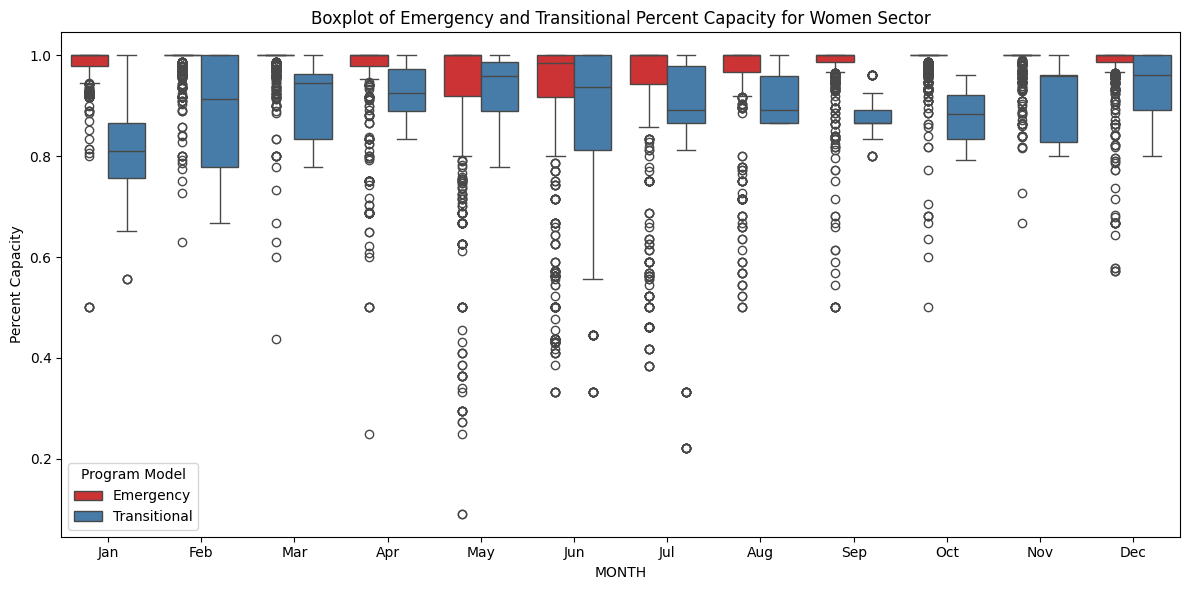

In [244]:
plot_programs_by_month(housingEntire, sector='Women')